In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [132]:
df = pd.read_csv('data/clean_nonull.csv')

df = pd.concat([
    df.drop(columns=['VKORC1_SNP', 'CYP2C9 consensus']),
    pd.get_dummies(df['VKORC1_SNP'], prefix='VKORC1_SNP', drop_first=True),
    pd.get_dummies(df['CYP2C9 consensus'], prefix='CYP2C9', drop_first=True)
], axis=1)

df['constant'] = 1

df['label'] = df['correct_dosage'].map({'low': 0, 'medium': 1, 'high': 2})

In [133]:
def clinical_baseline(x):
    x = np.squeeze(x)
    
    sqrt_weekly_dose = 4.0376 - 0.2546 * x[0] + 0.0118 * x[1] \
    + 0.0134 * x[2] - 0.6752 * x[3] \
    + 0.4060 * x[4] + 0.0443 * x[5] \
    + 1.2799 * x[6] - 0.5695 * x[7]
    
    
    cutoffs = np.array([0, np.sqrt(21), np.sqrt(49)])
    
    return np.where(cutoffs < sqrt_weekly_dose)[0].max()

In [134]:
np.random.seed(1)

S = 20


perfs = []
for s in tqdm(range(S)):
    order = np.random.choice(range(df.shape[0]), size=df.shape[0], replace=False)
    X = df.drop(columns=['correct_dosage', 'label']).iloc[order, :].values
    y = df['label'].values[order]
    
    #delta = 3 / X.shape[0] ## set it equal to |A|/T, for lack of a better option; see slides for UCB1 (lecture 10, slide 49)
    #R = 1  # arbitrarily
    #v = R * np.sqrt(9 * X.shape[1] * np.log(X.shape[0] / delta))
    v = np.sqrt(0.001)
    
    B = [np.eye(X.shape[1]) for _ in range(3)]
    F_h = [np.zeros(X.shape[1]) for _ in range(3)]
    mu_hat = [np.zeros(X.shape[1]) for _ in range(3)]

    chosen_arms = []
    for i in range(X.shape[0]):  # choose a patient        
        x_t = X[i] #/ np.linalg.norm(X[i])  # normalize vectors
        
        vals = []
        for a in range(3):
            mu_tilde = np.random.multivariate_normal(mu_hat[a], (v ** 2) * np.linalg.inv(B[a]))
            vals.append(mu_tilde.dot(x_t))
        
        pred_a = int(np.argmax(vals))
        
        r_t = 0 if y[i] == pred_a else -1
                
        # update the parameters
        B[pred_a] += np.outer(x_t, x_t)
        F_h[pred_a] += x_t * r_t
        mu_hat[pred_a] = np.linalg.inv(B[pred_a]).dot(F_h[pred_a])
        
        chosen_arms.append(pred_a)
        
    perf = pd.DataFrame({
        "run": s,
        "predicted_arm": chosen_arms,
        "true_arm": y,
        "clincal_baseline_predicted_arm": [clinical_baseline(x) for x in X]
    })

    perf['cumulative_accuracy'] = (
        perf['predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)
    
    perf['cumulative_fixed_baseline_accuracy'] = (
        perf['true_arm'] == 1
    ).cumsum() / (perf.index + 1)
    
    perf['cumulative_clinical_baseline_accuracy'] = (
        perf['clincal_baseline_predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_regret'] = -1 * np.where(
        perf['predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perf['cumulative_fixed_baseline_regret'] = -1 * np.where(
        perf['true_arm'] == 1,
        0,
        -1
    ).cumsum()
    
    perf['cumulative_clinical_baseline_regret'] = -1 * np.where(
        perf['clincal_baseline_predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perfs.append(perf)

ts_performances = pd.concat(perfs)
ts_performances['t'] = ts_performances.index

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  5.96s/it]


<AxesSubplot:xlabel='t'>

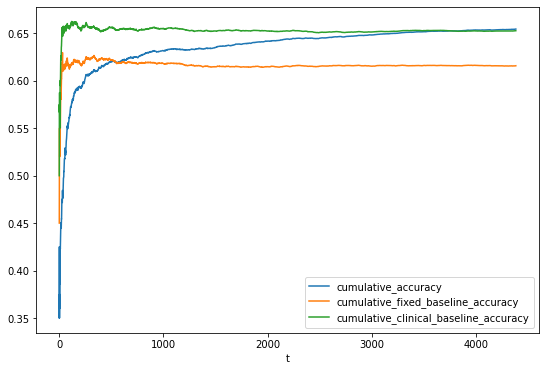

In [137]:
ts_grouped = ts_performances.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy', 'cumulative_clinical_baseline_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret', 'cumulative_clinical_baseline_regret'
]].mean()    

ts_grouped[[
    'cumulative_accuracy',
    'cumulative_fixed_baseline_accuracy',
    'cumulative_clinical_baseline_accuracy'
]].plot(figsize=(9,6))

<AxesSubplot:xlabel='t'>

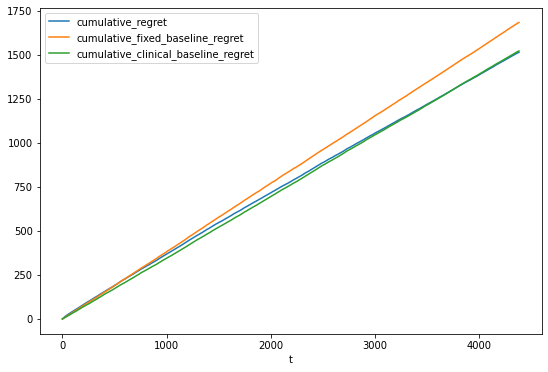

In [138]:
ts_grouped[[
    'cumulative_regret',
    'cumulative_fixed_baseline_regret',
    'cumulative_clinical_baseline_regret'
]].plot(figsize=(9,6))

In [139]:
ts_grouped.to_csv('ts_results.csv', index=False)
ts_performances.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy', 'cumulative_clinical_baseline_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret', 'cumulative_clinical_baseline_regret'
]].std().to_csv('ts_results_std.csv', index=False)